In [1]:
%reload_ext autoreload

In [9]:
%autoreload
from timegan_cnn import *
#from timegan_cnn_DG import *
from utils import *


trainset = TimeGANDatasetSinus(num=600, seq_len=100, features=3, temporal=True)
testset = TimeGANDatasetSinus(num=300, seq_len=100, features=3, temporal=True)
print(len(trainset))
print(trainset[0][0].size())


600
torch.Size([100, 3])


In [10]:
%autoreload
import neptune.new as neptune

run = neptune.init_run(
    project="kohmann/timeGAN",
    name="timegan_cnn",
    tags=["cnn", "batchnorm", "temporal"],
    description="New Generator architecutre w/ batchnorm",
    source_files=["timegan_cnn.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)


device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "n_epochs": 400,
    "l_rate": 0.001,
    "batch_size": 128,
    "num_layers": 2,
    "hidden_dim": 20,
    "Z_dim": 100,
    "dis_thresh": 0.15,
    "dataset": "sinus",
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
    "optimizer": "Adam",
}
run["parameters"] = params




model = TimeGAN(feature_dim=params["feature_dim"],
                hidden_dim=params["hidden_dim"],
                num_layers=params["num_layers"],
                padding_value=0.,
                Z_dim=params["Z_dim"],
                max_seq_len=params["max_seq_len"],
                batch_size=params["batch_size"],
                device=torch.device(params["device"]))

timegan_trainer(model,
                trainset,
                batch_size=params["batch_size"],
                device=torch.device(params["device"]),
                learning_rate=params["l_rate"],
                n_epochs=params["n_epochs"],
                max_seq_len=params["max_seq_len"],
                dis_thresh=params["dis_thresh"],
                neptune_logger=run,
                )
# Generate random synthetic data
gen_z = timegan_generator(model, torch.tensor(testset.T), "model.pt", torch.device(device), testset[0][0].size(0), 100)

r = np.array([data[0].numpy() for data in testset])
f_pca = visualization(r, gen_z, 'pca')
run["PCA"].upload(f_pca)
plt.close(f_pca)
f_tsne = visualization(r, gen_z, 'tsne')
run["tsne"].upload(f_tsne)
plt.close(f_tsne)

run["mode_collapse"] = modeCollapseEvaluator(r, gen_z)


run.stop()

https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-76
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.

Start Embedding Network Training


Epoch: 399, Loss: 0.0123: 100%|██████████| 400/400 [00:38<00:00, 10.52it/s]



Start Training with Supervised Loss Only


Epoch: 399, Loss: 0.0093: 100%|██████████| 400/400 [00:27<00:00, 14.34it/s]



Start Joint Training


Epoch: 399, E: 0.2723, G: 3.4805, D: 1.2716: 100%|██████████| 400/400 [06:34<00:00,  1.02it/s]


Training Complete and Model Saved

Generating Data...Done


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Real std:  [1.0590179  0.96926516]
Fake std:  [0.64530826 0.54601496]
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 25 operations to synchronize with Neptune. Do not kill this process.
All 25 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/timeGAN/e/TIMEGAN-76


In [23]:
gen_z = timegan_generator(model, torch.tensor(testset.T), "model.pt", torch.device(device), testset[0][0].size(0),
                          100)


Generating Data...Done


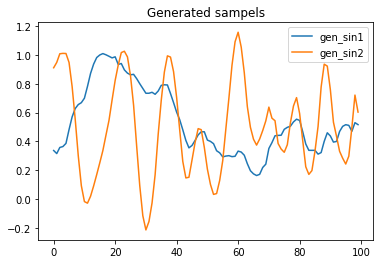

In [13]:
sample = 15
plt.plot(gen_z[sample][:, 0], label="gen_sin1")
plt.plot(gen_z[sample][:, 1], label="gen_sin2")
#plt.plot(gen_z[sample][:, 2], label="gen_sin3")
plt.title("Generated sampels")
plt.legend()

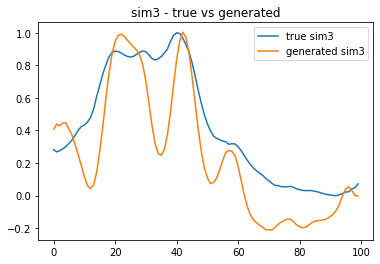

In [26]:
sample = 5
real_combo = create_sin3(gen_z[sample][:,0], gen_z[sample][:,0], temporal=True)
real_comb_scaled = minmaxscaler().fit_transform(torch.tensor([real_combo]))[0]
gen_combo = gen_z[sample][:,2]
plt.plot(real_comb_scaled, label="true sim3")
plt.plot(gen_combo, label="generated sim3")
plt.title("sim3 - true vs generated")
plt.legend()

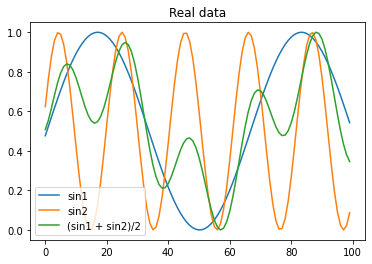

In [5]:
sample = trainset.__getitem__(5)
plt.plot(sample[0][:,0], label="sin1")
plt.plot(sample[0][:,1], label="sin2")
plt.plot(sample[0][:,2], label="(sin1 + sin2)/2")
plt.title("Real data")
plt.legend()

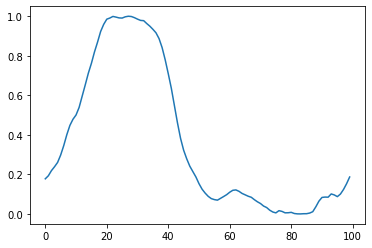

In [20]:
real_comb = create_sin3(gen_z[sample][:,0], gen_z[sample][:,0], temporal=True)
real_comb_scaled = minmaxscaler().fit_transform(torch.tensor([real_combo]))
plt.plot(real_comb_scaled[0])

### CNN layer testing

In [115]:
def printLayerShapes(layers, input):
    for layer in layers:
        output = layer(input)
        print(f"{type(layer).__name__}: {list(input.size())} --> {list(output.size())}")
        input = output

In [112]:
import torch
import torch.nn as nn
input = torch.randn(20, 100, 20)


## Discrininator
layers = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=20, kernel_size=(5), stride=2, bias=False)
            #,nn.Flatten(start_dim=1)
            ,nn.BatchNorm1d(20)
            ,nn.LeakyReLU()
            ,nn.Conv1d(in_channels=20, out_channels=40, kernel_size=(7), stride=2, bias=False)
            #,nn.Flatten(start_dim=1)
            ,nn.BatchNorm1d(40)
            ,nn.LeakyReLU()
            ,nn.Flatten(start_dim=1)
            ,nn.Linear(40, 1)
        )
printLayerShapes(layers, input)

Conv1d: [20, 100, 20] --> [20, 20, 8]
BatchNorm1d: [20, 20, 8] --> [20, 20, 8]
LeakyReLU: [20, 20, 8] --> [20, 20, 8]
Conv1d: [20, 20, 8] --> [20, 40, 1]
BatchNorm1d: [20, 40, 1] --> [20, 40, 1]
LeakyReLU: [20, 40, 1] --> [20, 40, 1]
Flatten: [20, 40, 1] --> [20, 40]
Linear: [20, 40] --> [20, 1]


In [95]:
## Generator
input = torch.randn(20, 100, 100)

layers = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(6), stride=2, bias=False)
            , nn.BatchNorm1d(100)
            , nn.LeakyReLU()
            , nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(9), stride=2, bias=True)
        )

printLayerShapes(layers, input)

Conv1d: [20, 100, 100] --> [20, 100, 48]
BatchNorm1d: [20, 100, 48] --> [20, 100, 48]
LeakyReLU: [20, 100, 48] --> [20, 100, 48]
Conv1d: [20, 100, 48] --> [20, 100, 20]


In [124]:
# Recovery

## Discrininator
layers = nn.Sequential(
            nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(5), stride=2, bias=False)
            #,nn.Flatten(start_dim=1)
            ,nn.BatchNorm1d(100)
            ,nn.LeakyReLU()
            ,nn.Conv1d(in_channels=100, out_channels=100, kernel_size=(3), stride=2, bias=True)

        )
printLayerShapes(layers, input)


Conv1d: [20, 100, 20] --> [20, 100, 8]
BatchNorm1d: [20, 100, 8] --> [20, 100, 8]
LeakyReLU: [20, 100, 8] --> [20, 100, 8]
Conv1d: [20, 100, 8] --> [20, 100, 3]


In [132]:
output = layers[0](input)

In [79]:
class EmbeddingNetwork(nn.Module):

    def __init__(self, feature_dim, hidden_dim, num_layers, padding_value, max_seq_len):
        super().__init__()
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.padding_value = padding_value
        self.max_seq_len = max_seq_len

        self.emb_rnn = nn.GRU(
            input_size=self.feature_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
        )

        self.emb_rnn2 = nn.Conv2d(in_channels=1,
                                  out_channels=16,
                                  kernel_size=3)


        self.emb_linear = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.emb_sigmoid = nn.Sigmoid()

        rnn_weight_init(self.emb_rnn)
        linear_weight_init(self.emb_linear)

    def forward(self, X, T):
        print("Input X:", X.size())
        X_packed = nn.utils.rnn.pack_padded_sequence(
            input=X,
            lengths=T,
            batch_first=True,
            enforce_sorted=False
        )

        H_o, H_t = self.emb_rnn(X_packed)

        H_o, T = nn.utils.rnn.pad_packed_sequence(
            sequence=H_o,
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len
        )


        logits = self.emb_linear(H_o)
        H = self.emb_sigmoid(logits)
        return H

In [80]:


device = "cpu"
feature_dim = trainset[0][0].size(1)
model = EmbeddingNetwork(feature_dim=feature_dim,
                hidden_dim=20,
                num_layers=1,
                padding_value=0.,
                max_seq_len=trainset[0][0].size(0),
                )
model.to(device)

batch_size = 32
batched_data  = torch.utils.data.DataLoader(
        dataset=trainset,
        batch_size=batch_size,
        shuffle=True
    )

for X, T in batched_data:
    X = X.unsqueeze(1)
    pred = model.forward(X, T)
    print(pred.size())
    break


Input X: torch.Size([32, 1, 100, 3])


RuntimeError: input must have 2 dimensions, got 3